In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib widget

## Gradient Descent

Simple Gradient Descent involves starting from an arbitrary point, and moving in the direction opposite to the maximum gradient

$$\begin{align}
&{\rm algorithm\; G{\scriptsize RADIENT}\text{-D}{\scriptsize ESCENT}}\; (\theta^{(0)}, \eta, \mathcal{L}):\\
&t \leftarrow 0 \\
&\text{do} \\
&\quad \theta^{(t+1)} \leftarrow \theta^{(t)} - \eta \; \nabla_\theta \mathcal{L}(\theta^{(t)}) \\
&\quad t \leftarrow t+1 \\
&\text{while not converged} \\
&\text{return }\theta^{(t)} 
\end{align}
$$

$\eta$ defines the learning rate, while $\mathcal{L}$ is the loss function

Here, we do a simple univariate regression on a random sample from the [Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant). 

In [3]:
ccpp_all_samples = pd.read_csv('../data/CCPP/output.csv')
ccpp_all_samples.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [4]:
df = ccpp_all_samples.sample(500)
df.head()

,AT,V,AP,RH,PE
8103,19.06,56.65,1020.82,82.14,455.70
8879,26.45,47.43,1008.87,53.25,442.12
5955,25.91,75.60,1018.23,62.65,443.20
6977,25.48,65.12,1016.12,53.66,447.85
5706,13.58,44.47,1029.91,70.41,467.15


In [5]:
x = df['AT'].to_numpy()
y = df['PE'].to_numpy()
#y = (y - y.mean())/y.std()
#x = (x - x.mean())/x.std()

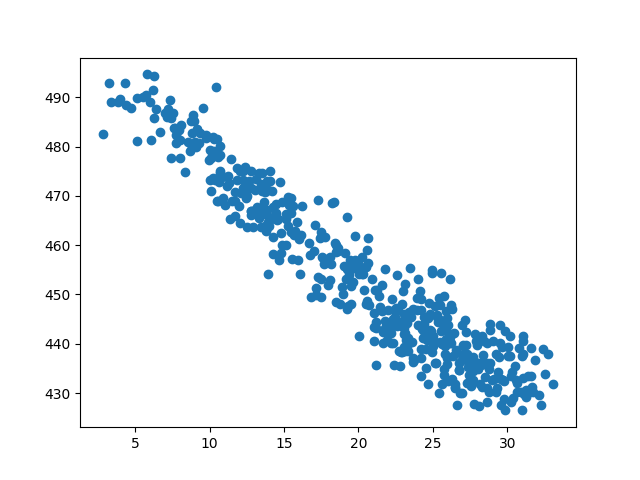

In [6]:
plt.scatter(x,y)

Data seems nice: simple, linearly dependent and homoscedastic. Let's make a loss function for this

In [18]:
def loss(x, y, theta_0, theta_1):
    return (((y-theta_0-theta_1*x)**2)/(2*len(y))).sum()

def grad_loss(weights, theta_0, theta_1):
    (x,y) = weights
    return (-(y-theta_0-theta_1*x).mean(),(-x*(y-theta_0-theta_1*x)).mean())

def grad_loss_0(x, y, theta_0, theta_1):
    return -(y-theta_0-theta_1*x).mean()

def grad_loss_1(x, y, theta_0, theta_1):
    return (-x*(y-theta_0-theta_1*x)).mean()

And now plot the contours so we get an idea of our parameters

Text(0.5, 0, 'loss')

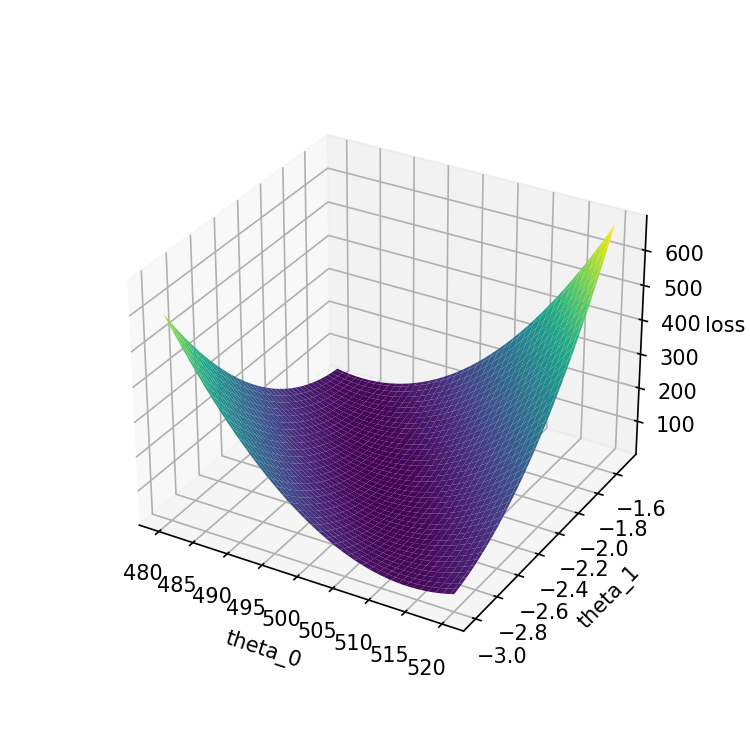

In [34]:
theta_0_space = np.linspace(480,520,80)
theta_1_space = np.linspace(-3,-1.5,80)
theta_space   = np.meshgrid(theta_0_space, theta_1_space)

vector_loss = np.vectorize(loss, signature='(m),(m),(),()->()')
loss_space = vector_loss(x, y, theta_space[0], theta_space[1])

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.axes(projection='3d')
ax.plot_surface(theta_space[0], theta_space[1], loss_space, cmap='viridis', edgecolor=None)
#ax.contour3D(theta_space[0], theta_space[1], loss_space, 50, cmap='binary')
ax.set_xlabel('theta_0')
ax.set_ylabel('theta_1')
ax.set_zlabel('loss')

#CS = plt.contour(theta_0_space, theta_1_space, loss_space)
#plt.clabel(CS, fmt = '%2.1d', colors = 'k', fontsize=14) #contour line labels
#plt.quiver(theta_0_space,theta_1_space,grad_loss_space_0,grad_loss_space_1)

In [35]:
# now the GD algo
def gradient_descent(params, theta_0, theta_1, grad_loss, eta, t_lim=1000):
    
    theta_0_pts = [theta_0]
    theta_1_pts = [theta_1]
    
    t = 0
    
    while t < t_lim:
        loss_grad = grad_loss(params, theta_0_pts[-1], theta_1_pts[-1])
        #print(loss_grad)
        theta_0_n = theta_0_pts[-1] - eta*loss_grad[0]
        theta_1_n = theta_1_pts[-1] - eta*loss_grad[1]
        
        if (abs(theta_0_n-theta_0_pts[-1]) < 0.00001 and abs(theta_1_n-theta_1_pts[-1]) < 0.00001):
            break
        
        theta_0_pts.append(theta_0_n)
        theta_1_pts.append(theta_1_n)
        
        t += 1
            
    return (theta_0_pts, theta_1_pts)

Text(0.5, 0, 'loss')

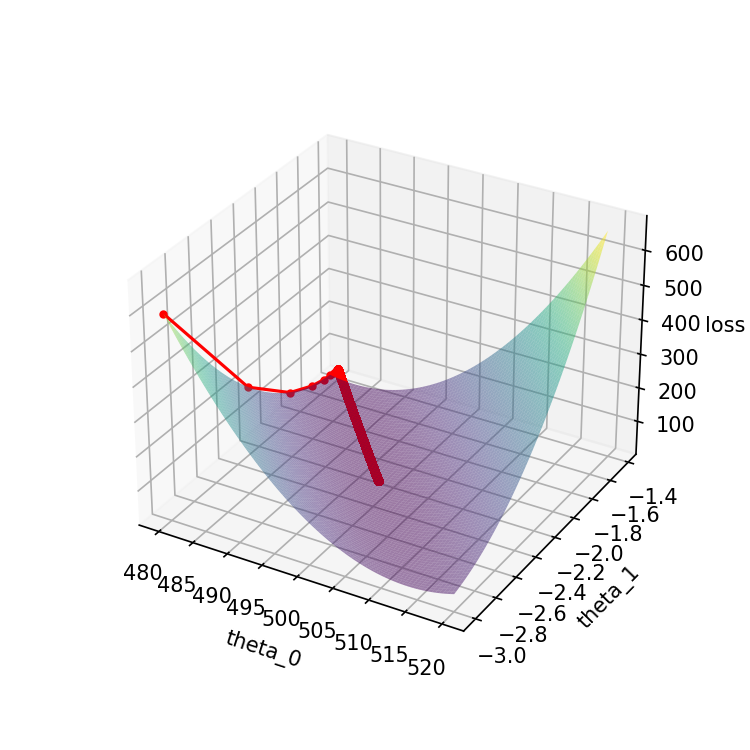

In [36]:
fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.axes(projection='3d')

gd_pts = gradient_descent((x,y),480,-3,grad_loss,0.001,t_lim=100000)
gd_loss = [loss(x,y,gd_pt[0],gd_pt[1]) for gd_pt in zip(gd_pts[0],gd_pts[1])]
ax.plot3D(gd_pts[0], gd_pts[1], gd_loss, color='r', marker='.')

ax.plot_surface(theta_space[0], theta_space[1], loss_space, rstride=1, cstride=1, cmap='viridis', edgecolor=None, alpha=0.5)
#ax.contour3D(theta_space[0], theta_space[1], loss_space, 50, cmap='binary')
ax.set_xlabel('theta_0')
ax.set_ylabel('theta_1')
ax.set_zlabel('loss')
#plt.savefig('grad_not_perp.png')

See [Goodfellow et al, Chp4](https://www.deeplearningbook.org/contents/numerical.html). Note that our parameter space seems like a simple elliptic paraboloid, but it's a bit more complicated; rather than two, this one has 500 axes (for different values of $y^{(i)}$ and $x^{(i)}$). Here's an example, where we fit the following curve to the loss data and do gradient descent on it:

$$t(\vec{\theta},(x,y)) = \theta_0 + \theta_1 x^2 + \theta_2 y^2 + \theta_3 xy + \theta_4 x + \theta_5 y$$

Using the notation from bishop, this gives us

$$\phi^T((x,y)) = (1,x^2,y^2,xy,x,y)$$

which is our feature vector. I'll use the closed form of regression to fit to this, rather than do gradient descent.

<sub>Note this is not really relevant; it just gives me an excuse to do some polynomial regression</sub>

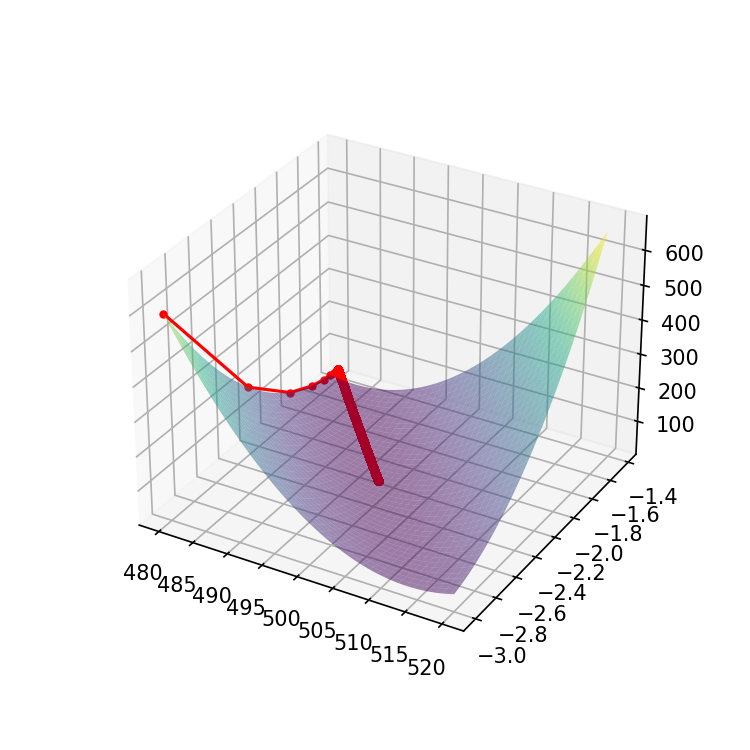

In [48]:
# points to fit
ts_pts = np.squeeze(np.dstack([theta_space[0].ravel(), theta_space[1].ravel()]))
fit_pts = loss_space.ravel()

def f(theta,x,y):
    return theta.T@phi((x,y))

def phi(p):
    x,y = p
    return np.array([1,x*x,y*y,x*y,x,y])

def design_mat(x_all,phi):
    return np.vstack([phi(p) for p in x_all])

def theta(Phi,t):
    return np.linalg.pinv(Phi)@t

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.axes(projection='3d')

th = theta(design_mat(ts_pts,phi),fit_pts)
vector_f = np.vectorize(f, signature='(m),(),()->()')
fitted_loss_space = vector_f(th, theta_space[0], theta_space[1])

ax.plot_surface(theta_space[0], theta_space[1], fitted_loss_space, cmap='viridis', edgecolor=None, alpha=0.5)

def grad_mv(theta,x,y):
   return (theta[4]+theta[3]*y+2*theta[1]*x,theta[5]+theta[3]*x+2*theta[2]*y)

gd_pts = gradient_descent(th,480,-3,grad_mv,0.001,t_lim=100000)
gd_loss = [f(th,gd_pt[0],gd_pt[1]) for gd_pt in zip(gd_pts[0],gd_pts[1])]
ax.plot3D(gd_pts[0], gd_pts[1], gd_loss, color='r', marker='.')